In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

# 打印显卡信息，确认GPU可用
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

import pathlib

data_dir = "./data"

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：",image_count)

图片总数为： 4000


In [3]:
batch_size = 4
img_height = 299
img_width  = 299

"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4000 files belonging to 4 classes.
Using 3200 files for training.


In [4]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4000 files belonging to 4 classes.
Using 800 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['cat', 'chook', 'dog', 'horse']


In [6]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(4, 299, 299, 3)
(4,)


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds.cache()
    .shuffle(1000)
#     .map(train_preprocessing)    # 这里可以设置预处理函数
#     .batch(batch_size)           # 在image_dataset_from_directory处已经设置了batch_size
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache()
    .shuffle(1000)
#     .map(val_preprocessing)    # 这里可以设置预处理函数
#     .batch(batch_size)         # 在image_dataset_from_directory处已经设置了batch_size
    .prefetch(buffer_size=AUTOTUNE)
)

In [8]:
#====================================#
#     Xception的网络部分
#====================================#
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,BatchNormalization,Activation,Conv2D,SeparableConv2D,MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions


def Xception(input_shape = [299,299,3],classes=1000):

    img_input = Input(shape=input_shape)
    
    #=================#
    #   Entry flow
    #=================#
    #  block1
    # 299,299,3 -> 149,149,64
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)


    # block2
    # 149,149,64 -> 75,75,128
    residual = Conv2D(128, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    x = layers.add([x, residual])

    # block3
    # 75,75,128 -> 38,38,256
    residual = Conv2D(256, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    # block4
    # 38,38,256 -> 19,19,728
    residual = Conv2D(728, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    x = layers.add([x, residual])

    #=================#
    # Middle flow
    #=================#
    # block5--block12
    # 19,19,728 -> 19,19,728
    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    #=================#
    #    Exit flow
    #=================#
    # block13
    # 19,19,728 -> 10,10,1024
    residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    # block14
    # 10,10,1024 -> 10,10,2048
    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    inputs = img_input

    model = Model(inputs, x, name='xception')

    return model

In [9]:
model = Xception()
# 打印模型信息
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 37, 37, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 37, 37, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 37, 37, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 19, 19, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 19, 19, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 19, 19, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 19, 19, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 19, 19, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 19, 19, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 19, 19, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 19, 19, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 19, 19, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [10]:
# 设置初始学习率
initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, 
        decay_steps=300,      # 敲黑板！！！这里是指 steps，不是指epochs
        decay_rate=0.96,     # lr经过一次衰减就会变成 decay_rate*lr
        staircase=True)

# 将指数衰减学习率送入优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [11]:
model.compile(optimizer=optimizer,
              loss     ='sparse_categorical_crossentropy',
              metrics  =['accuracy'])

In [12]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
800/800 [==============================] - 464s 564ms/step - loss: 1.4314 - accuracy: 0.4584 - val_loss: 1.0577 - val_accuracy: 0.5475
Epoch 2/20
800/800 [==============================] - 447s 559ms/step - loss: 0.9087 - accuracy: 0.6228 - val_loss: 0.8191 - val_accuracy: 0.6612
Epoch 3/20
800/800 [==============================] - 446s 558ms/step - loss: 0.6728 - accuracy: 0.7403 - val_loss: 0.8190 - val_accuracy: 0.6687
Epoch 4/20
800/800 [==============================] - 447s 559ms/step - loss: 0.3362 - accuracy: 0.8841 - val_loss: 0.8249 - val_accuracy: 0.6913
Epoch 5/20
800/800 [==============================] - 447s 559ms/step - loss: 0.1415 - accuracy: 0.9566 - val_loss: 0.9374 - val_accuracy: 0.6975
Epoch 6/20
800/800 [==============================] - 446s 558ms/step - loss: 0.0840 - accuracy: 0.9809 - val_loss: 1.2619 - val_accuracy: 0.6737
Epoch 7/20
800/800 [==============================] - 447s 558ms/step - loss: 0.0574 - accuracy: 0.9862 - val_loss: 0.7897 -

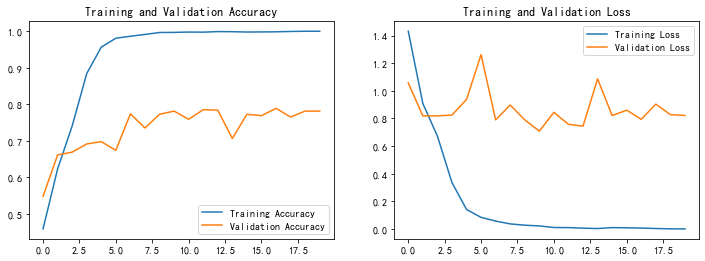

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('pic2.jpg', dpi=600) #指定分辨率保存
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# 定义一个绘制混淆矩阵图的函数
def plot_cm(labels, predictions):
    
    # 生成混淆矩阵
    conf_numpy = confusion_matrix(labels, predictions)
    # 将矩阵转化为 DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(8,7))
    
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
    plt.title('混淆矩阵',fontsize=15)
    plt.ylabel('真实值',fontsize=14)
    plt.xlabel('预测值',fontsize=14)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


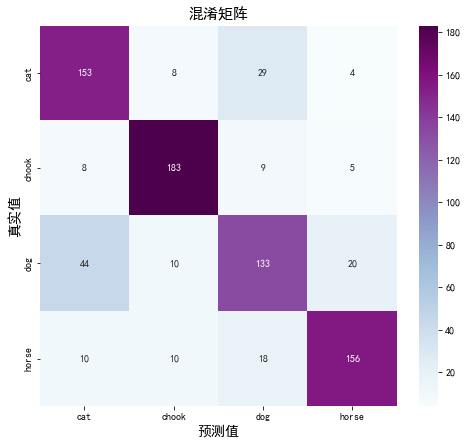

In [15]:
val_pre   = []
val_label = []

for images, labels in val_ds:#这里可以取部分验证数据（.take(1)）生成混淆矩阵
    for image, label in zip(images, labels):
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(image, 0) 
        # 使用模型预测图片中的人物
        prediction = model.predict(img_array)

        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])
plot_cm(val_label, val_pre)

In [17]:
# 保存模型
model.save('model/model.h5')
# 加载模型
new_model = tf.keras.models.load_model('model/model.h5')